# This notebook generates figure08, which show that thermal resistance is the controlling variable for Ic suppression during irradiation.

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import sys, os, importlib, seaborn as sns, pandas as pd

outputDirectory = 'raw/'
parentDirectory = 'data/'
sys.path.append('../../../')
sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')

import default_style as dfs
import hts_dosecalculations as dose
import hts_fitfunctions as ff

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_style as dfs, hts_beamspot as bsp
for lib in [hts, ff, misc, dfs, bsp]:
    importlib.reload(lib)

########## Load data ############
#################################
masterfile = '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 4/figures/4-3 Degradation enhances suppression/data/data-master-linear.xlsx'
cols = [0, 1, 12, 13, 14, 41, 43, 45, 52, 55, 56, 59]
names = ['tapeid', 'anneal', 'energy', 'power', 'powerError', 'tTAR_OFF', 'tHTS_ON', 'tTAR_ON', 'tREBCO', 'suppression', 'suppressionError', 'outlier' ]
df = pd.read_excel(masterfile, sheet_name='data', usecols=cols, names=names, skiprows=1)

########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
data = df[cut]
print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())
for energy in data.energy.unique():
    print('\nDatapoints for', energy, data[data.energy==energy].energy.count())
df.columns



Total datapoints 656

Datapoints for f33 68

Datapoints for f20 11

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 206

Datapoints for 150 167

Datapoints for 800 136

Datapoints for 2400 129

Datapoints for 1200 224


Index(['tapeid', 'anneal', 'energy', 'power', 'powerError', 'tTAR_OFF',
       'tHTS_ON', 'tTAR_ON', 'tREBCO', 'suppression', 'suppressionError',
       'outlier'],
      dtype='object')

## Figure 08 description

This figure compares tapes ffj29, ffj37 and ffj33 in terms of the temperature rise in REBCO as a function of ion beam power. There are two additional trend lines for the datasets corresponding to ffj29 and ffj37 after the first anneal. It is observed that the first (and only the first) anneal causes a change in thermal resistance, whose explanation is left for further investigation. The light colored enveloped are the result of 2D thermal modeling, aimed at reproducing the temperature in the tape during irradiation using the sensor temeprature as input and the thermal resistance at the tape/target boundary as the single free parameter. 

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_95434/2929697899.py:25: SyntaxWarning: invalid escape sequence '\m'
  label = '{}'.format(tape)+'$\mathrm{^a}$'+' {} keV'.format(energy)
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_95434/2929697899.py:66: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{T_{REBCO} - T_{Cold mass}}$ [K]')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_95434/2929697899.py:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_95434/2

f29-1 Lower bound 2.00 [mK/W] Upper bound 2.60 [mK/W]
data/fem/f29-1/1200keV/f29_1200keV_deltaT_Apiezon=20um+Sensorpos=4.96mm.txt
data/fem/f29-1/1200keV/f29_1200keV_deltaT_Apiezon=26um+Sensorpos=4.96mm.txt
f29-2 Lower bound 1.50 [mK/W] Upper bound 1.90 [mK/W]
data/fem/f29-2/1200keV/f29_1200keV_deltaT_Apiezon=15um+Sensorpos=4.96mm.txt
data/fem/f29-2/1200keV/f29_1200keV_deltaT_Apiezon=19um+Sensorpos=4.96mm.txt
f37-1 Lower bound 0.80 [mK/W] Upper bound 1.40 [mK/W]
data/fem/f37-1/1200keV/f37_1200keV_deltaT_Apiezon=8um+Sensorpos=4.96mm.txt
data/fem/f37-1/1200keV/f37_1200keV_deltaT_Apiezon=14um+Sensorpos=4.96mm.txt
f37-2 Lower bound 0.50 [mK/W] Upper bound 0.70 [mK/W]
data/fem/f37-2/2400keV/f37_2400keV_deltaT_Apiezon=5um+Sensorpos=4.96mm.txt
data/fem/f37-2/2400keV/f37_2400keV_deltaT_Apiezon=7um+Sensorpos=4.96mm.txt
f33-1 Lower bound 0.08 [mK/W] Upper bound 0.18 [mK/W]
data/fem/f33-1/150keV/f33_150keV_deltaT_Apiezon=0.8um+Sensorpos=4.96mm.txt
data/fem/f33-1/150keV/f33_150keV_deltaT_Apiezon=1.

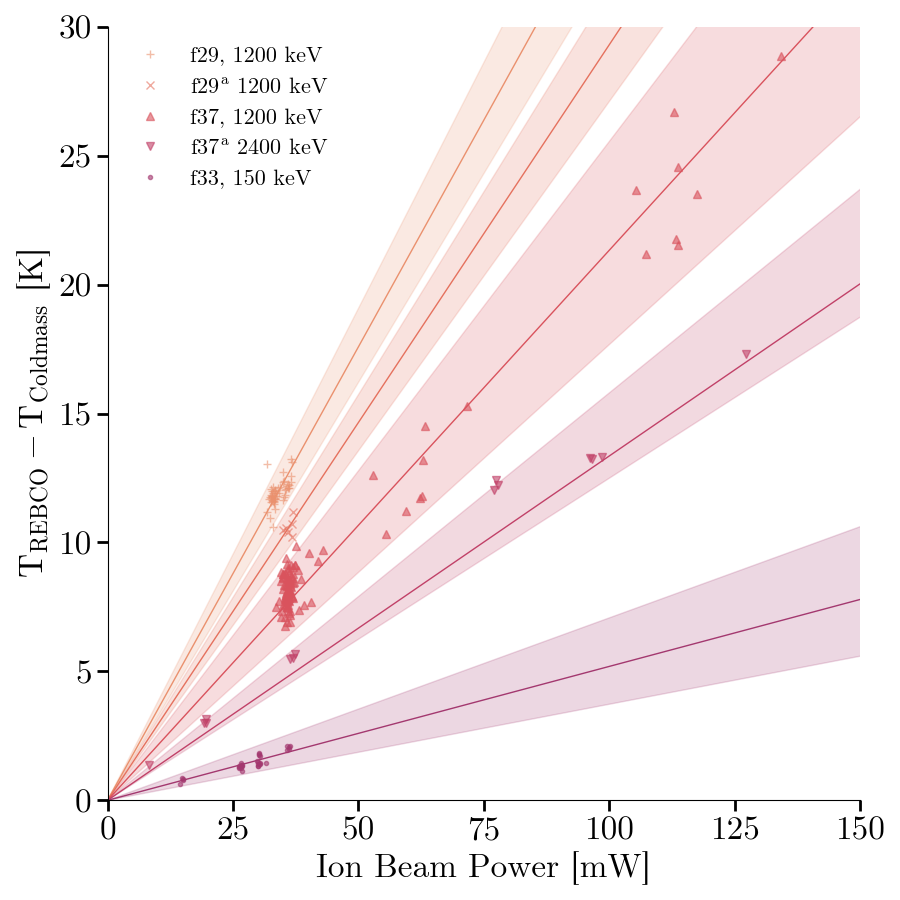

In [8]:
fig, ax = plt.subplots(1, 1)
fitfunction = ff.affine
xsmooth = np.linspace(0, 200, 1000)

datasets = ['f29-1', 'f29-2', 'f37-1', 'f37-2', 'f33-1', 'f20-1', 'f34-1']
energies = [1200, 1200, 1200, 2400, 150, 150, 2400]
markers = ['+', 'x', '^', 'v', '.', 's', 'd']
plotYN = [True, True, True, True, True, False, False]
colors = sns.color_palette('flare', len(datasets))

for dataset, energy, plot, m, c in zip(datasets, energies, plotYN, markers, colors):
    if plot:
        tape, anneal = dataset.split('-')[0], int(dataset.split('-')[1])
        cut = (data.tapeid == tape)
        cut &= (data.energy == energy)
        if anneal > 1:
            cut &= (data.anneal > 1)
        else:
            cut &= (data.anneal == 1)
        cut &= (data.tREBCO-data.tTAR_ON > 0) # Some corrections fail and produce tREBCO = 0, which leads to a negative dT.
        d = data[cut]

        # plot the data and affine fit
        if anneal > 1:
            label = '{}'.format(tape)+'$\mathrm{^a}$'+' {} keV'.format(energy)
        else:
            label = '{}, {} keV'.format(tape, energy)
        x, ex = d.power, d.powerError
        y, ey = d.tREBCO-d.tTAR_ON, np.zeros_like(d.powerError)
        popt, pcov = curve_fit(ff.affine, x, y)
        ax.plot(xsmooth, ff.affine(xsmooth, *popt), color=c, alpha=1, linewidth=1)
        ax.plot(x, y, linestyle='None', linewidth=.5, marker=m, markersize=6, alpha=.6, color=c, label=label)

        # plot model fit
        path_to_files = 'data/fem/{}/{}keV/'.format(dataset, energy)
        minThickness, maxThickness = 100, 0 # find the extreme cases of the simulation 
        for fpath in [path_to_files+f for f in os.listdir(path_to_files) if 'DS_Store' not in f]:
            thickness = float(fpath.split('/')[-1].split('=')[1].split('um+')[0])
            if thickness < minThickness: minThickness = thickness
            if thickness > maxThickness: maxThickness = thickness

        if float(int(minThickness)) == minThickness: minThickness = int(minThickness)
        if float(int(maxThickness)) == maxThickness: maxThickness = int(maxThickness)
        
        print(dataset, 'Lower bound {:<4.2f} [mK/W]'.format(minThickness*1e-1), 'Upper bound {:4.2f} [mK/W]'.format(maxThickness*1e-1))
        print(path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, minThickness))
        print(path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, maxThickness))
        
        # get lower bound fit
        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, minThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTREBCO
        popt_lower, _ = curve_fit(ff.affine, x, y)

        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, maxThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTREBCO
        popt_upper, _ = curve_fit(ff.affine, x, y)

        xsmooth = np.linspace(0, 200, 10000)
        ylower = ff.affine(xsmooth, *popt_lower)
        yupper = ff.affine(xsmooth, *popt_upper)
        ax.fill_between(x=xsmooth, y1=ylower, y2=yupper, color=c, alpha=.2)

ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('$\mathrm{T_{REBCO} - T_{Cold mass}}$ [K]')
ax.set_xlim(0, 150)
ax.set_ylim(0, 30)
ax.legend(loc='upper left', frameon=False)
fig.tight_layout()
plt.savefig(outputDirectory+'thermalResistance.svg', format='svg', facecolor='white')

<IPython.core.display.Javascript object>


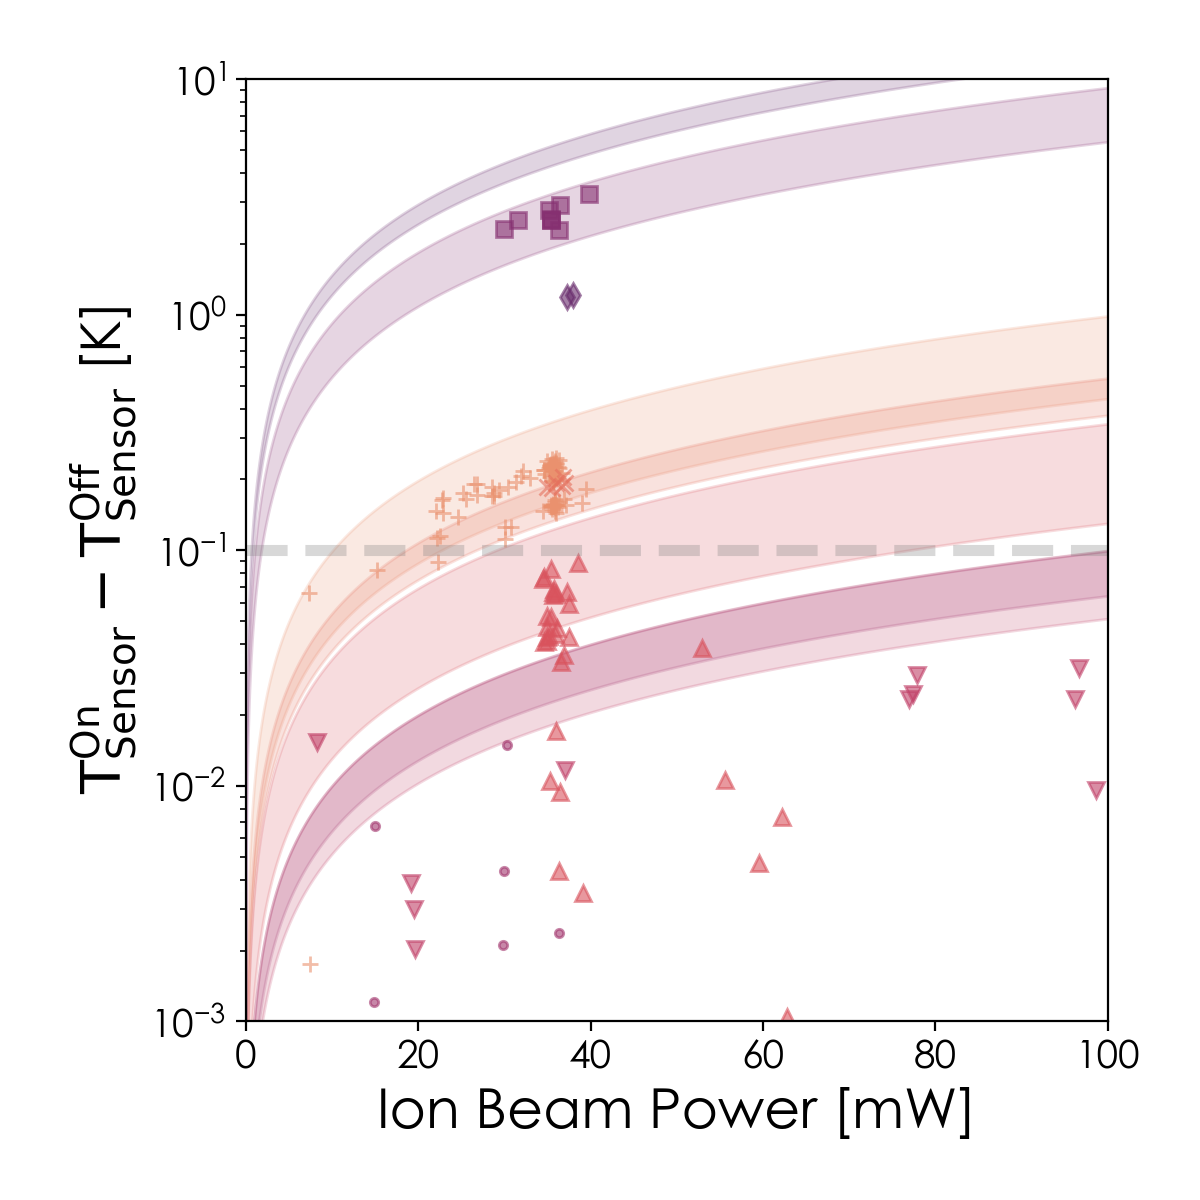

f29-1 Lower bound 1.50 [mK/W] Upper bound 2.60 [mK/W]
f29-2 Lower bound 1.50 [mK/W] Upper bound 1.90 [mK/W]
f37-1 Lower bound 0.80 [mK/W] Upper bound 1.40 [mK/W]
f37-2 Lower bound 0.50 [mK/W] Upper bound 0.70 [mK/W]
f33-1 Lower bound 0.08 [mK/W] Upper bound 0.18 [mK/W]
f20-1 Lower bound 0.70 [mK/W] Upper bound 1.10 [mK/W]
f34-1 Lower bound 3.50 [mK/W] Upper bound 4.10 [mK/W]


/Users/alexisdevitre/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine
xsmooth = np.linspace(0, 200, 1000)

datasets = ['f29-1', 'f29-2', 'f37-1', 'f37-2', 'f33-1', 'f20-1', 'f34-1']
energies = [150, 1200, 1200, 2400, 150, 150, 2400]
markers = ['+', 'x', '^', 'v', '.', 's', 'd']
plotYN = [True, True, True, True, True, True, True]
colors = sns.color_palette('flare', len(datasets))

for dataset, energy, plot, m, c in zip(datasets, energies, plotYN, markers, colors):
    if plot:
        tape = dataset.split('-')[0]

        cut = (data.tapeid == tape)
        cut &= (data.energy == energy)
        if int(dataset.split('-')[1]) > 1:
            cut &= (data.anneal > 1)
        else:
            cut &= (data.anneal == 1)
        cut &= (data.tREBCO-data.tTAR_ON > 0) # Some corrections fail and produce tREBCO = 0, which leads to a negative dT.
        d = data[cut]

        # plot the data and affine fit
        x, y = d.power, d.tHTS_ON#d.tTAR_ON
        popt, _ = curve_fit(ff.linear, x, y)
        y -= popt[1]
        x = x[y >= 0]
        y = y[y >= 0] # remove negative temperature, which are due to sensor fluctuations
        ax.semilogy(x, y, linestyle='None', linewidth=.5, marker=m, markersize=6, alpha=.6, color=c)

        # plot model fit
        path_to_files = '../data/fem/{}/{}keV/'.format(dataset, energy)
        minThickness, maxThickness = 100, 0 # find the extreme cases of the simulation 
        for fpath in [path_to_files+f for f in os.listdir(path_to_files) if 'DS_Store' not in f]:
            thickness = float(fpath.split('/')[-1].split('=')[1].split('um+')[0])
            if thickness < minThickness: minThickness = thickness
            if thickness > maxThickness: maxThickness = thickness

        if float(int(minThickness)) == minThickness: minThickness = int(minThickness)
        if float(int(maxThickness)) == maxThickness: maxThickness = int(maxThickness)
        
        print(dataset, 'Lower bound {:<4.2f} [mK/W]'.format(minThickness*1e-1), 'Upper bound {:4.2f} [mK/W]'.format(maxThickness*1e-1))
        
        # get lower bound fit
        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, minThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTSensor
        popt_lower, _ = curve_fit(ff.affine, x, y)

        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, maxThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTSensor
        popt_upper, _ = curve_fit(ff.affine, x, y)

        xsmooth = np.linspace(0, 200, 10000)
        ylower = ff.affine(xsmooth, *popt_lower)
        yupper = ff.affine(xsmooth, *popt_upper)
        ax.fill_between(x=xsmooth, y1=ylower, y2=yupper, color=c, alpha=.2)

ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('$\mathrm{T_{Sensor}^{On} - T_{Sensor}^{Off}}$ [K]')
ax.set_xlim(0, 100)
ax.set_ylim(1e-3, 1e1)
ax.axhline(0.1, linestyle='--', linewidth=4, color='gray', alpha=.3)
fig.tight_layout()
plt.savefig(outputDirectory+'figure08-thermalResistance.svg', format='svg', facecolor='white')